#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

Импорт необходимых библиотек:

In [84]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from lightgbm import LGBMRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

## 1. Подготовка

### 1.1. Загрузка данных и вывод основной информации

Чтение csv-файла и сохранение в переменную data:

In [85]:
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

Ресемплирование данных по одному часу:

In [86]:
data.sort_index(inplace=True)
data_h = data.resample('1H').sum()

Проверка хронологического порядка данных:

In [87]:
print(data_h.index.is_monotonic)

True


In [88]:
# Функция, выводящая основную информацию о датафрейме
def about_df(data, size=5):
    print(f'Вывод первых {size} строк датафрейма:')
    pd.set_option('display.max_columns', 30)
    display(data.head(size))
    print('\nВывод основной информации о датафрейме:')
    data.info()
    print('\nКоличество пропусков в датафрейме:')
    print(pd.DataFrame(np.array([data.isna().sum(), data.isna().mean()*100]).T, 
                                columns=['количество пропусков', 'доля пропусков, %'], index=data.columns))
    print(f'\nСуммарное количество пропусков в датафрейме: {data.isna().sum().sum()}, '
          + f'доля пропусков: {data.isna().mean().sum()*100} %')
    display(data.describe())

Вывод основной информации о датафрейме data:

In [89]:
about_df(data_h)

Вывод первых 5 строк датафрейма:


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43



Вывод основной информации о датафрейме:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB

Количество пропусков в датафрейме:
            количество пропусков  доля пропусков, %
num_orders                   0.0                0.0

Суммарное количество пропусков в датафрейме: 0, доля пропусков: 0.0 %


,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


<b>Вывод:</b>
- установлен индекс таблицы равным столбцу datetime;
- выполнено ресемлирование данных по одному часу;
- проведена проверка хронологического порядка данных;
- датафрейм содержит 4416 строк и 1 столбец;
- временной ряд содержит данные с марта по август 2018 года; 
- столбец num_orders является количественным целевым признаком (target), что соответствует задачи регрессии;
- в датафрейме отсутствуют пропущенные значения.

## 2. Анализ

Построим график заказов такси за весь период с марта по август 2018 года:

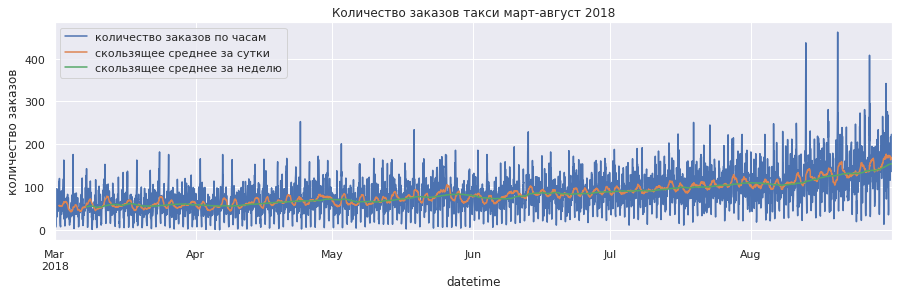

In [90]:
sns.set(rc={'figure.figsize':(15,4)})
fig, ax = plt.subplots()
w = data_h.plot(ax=ax)
w = data_h.rolling(24).mean().plot(ax=ax)
w = data_h.rolling(168).mean().plot(ax=ax)
w.set(title='Количество заказов такси март-август 2018', ylabel='количество заказов')
ax.legend(labels=['количество заказов по часам','скользящее среднее за сутки','скользящее среднее за неделю'])
plt.show()


В изучаемом периоде наблюдается увеличение количества заказов такси в аэропорт. Больше всего заказов в августе, что, вероятней всего, связано с периодом отпусков.<br> Разложим временной ряд на три составляющие: тренд, сезонность и остаток, и построим их графики.

In [91]:
decomposed = seasonal_decompose(data_h)

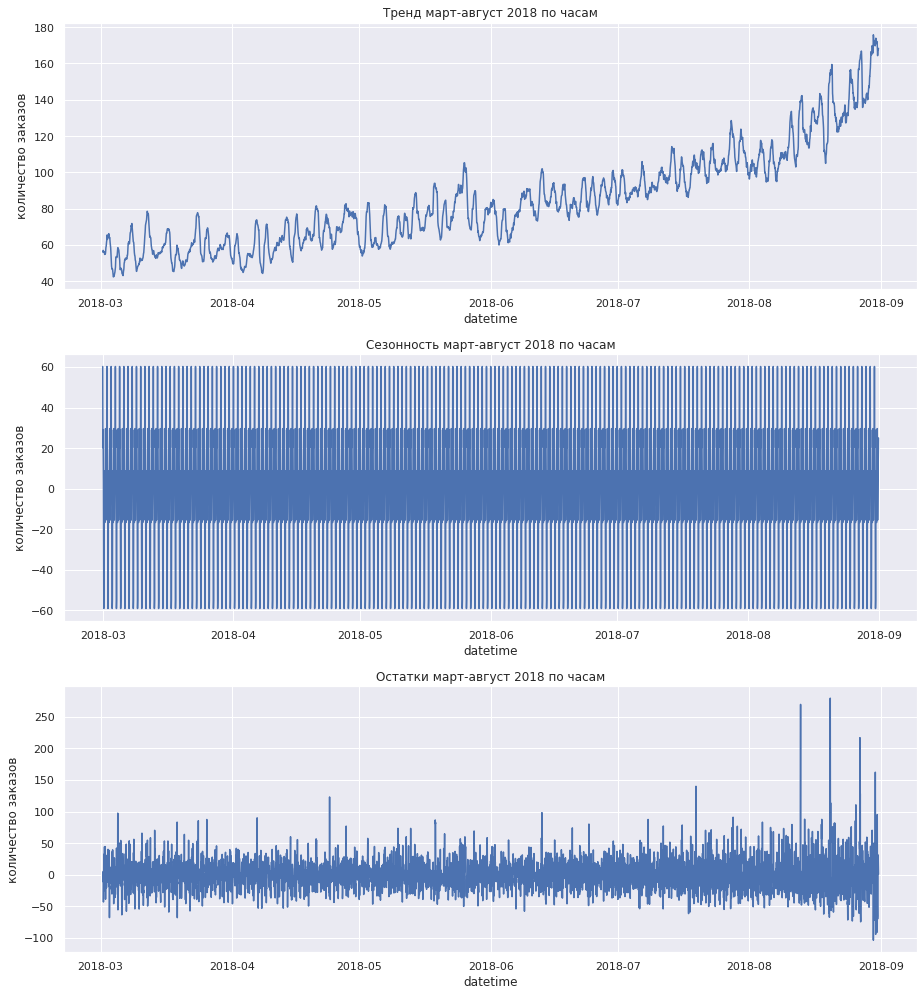

In [92]:
plt.figure(figsize = (13,14))
plt.subplot(311)
w=sns.lineplot(data=decomposed.trend)
w.set(title='Тренд март-август 2018 по часам', ylabel='количество заказов')
plt.subplot(312)
w=sns.lineplot(data=decomposed.seasonal)
w.set(title='Сезонность март-август 2018 по часам', ylabel='количество заказов')
plt.subplot(313)
w=sns.lineplot(data=decomposed.resid)
w.set(title='Остатки март-август 2018 по часам', ylabel='количество заказов')
plt.tight_layout()

- тренд со временем растет, значительный рост наблюдается с мая и усиливается в июле-августе;
- сезонность имеет период меньше месяца.

Продолжим исследование сезонности, для этого укрупним график, построим сезонность за первую неделю марта (с понедельника 5 марта по воскресенье 11 марта).

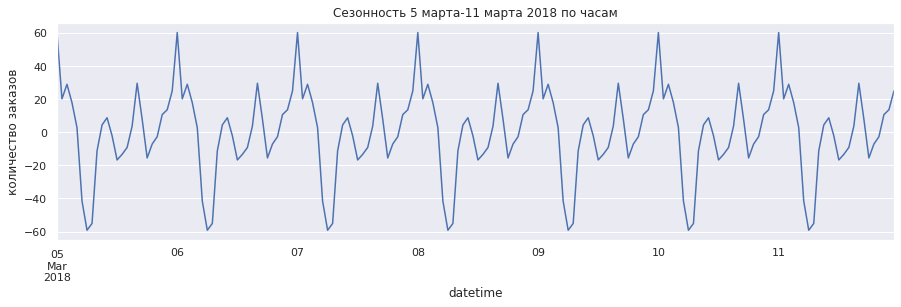

In [93]:
sns.set(rc={'figure.figsize':(15,4)})
w = decomposed.seasonal['2018-03-05':'2018-03-11'].plot()
w.set(title='Сезонность 5 марта-11 марта 2018 по часам', ylabel='количество заказов')
plt.show()

Рассмотрим сезонность в течение дня:

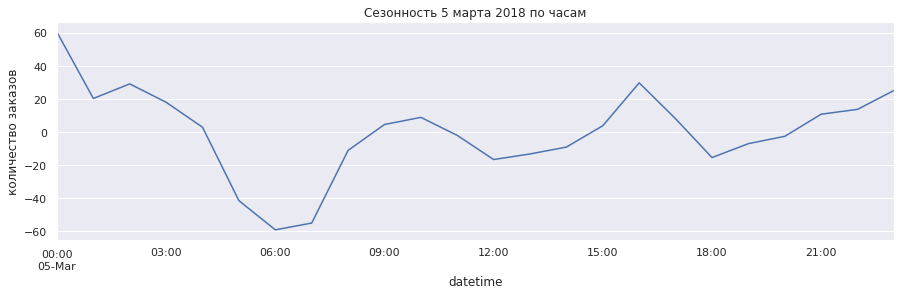

In [94]:
sns.set(rc={'figure.figsize':(15,4)})
w = decomposed.seasonal['2018-03-05'].plot()
w.set(title='Сезонность 5 марта 2018 по часам', ylabel='количество заказов')
plt.show()

Пик заказов такси приходится на ночь, к утру происходит спад, затем в течение дня количество заказов постепенно растет.

Сделаем ресемплинг данных по суткам:

In [95]:
data_d = data.resample('1D').sum()

Проверим хронологический порядок данных:

In [96]:
data_d.index.is_monotonic

True

Разложим аналгично временной ряд на три составляющие: тренд, сезонность и остаток, и построим их графики.

In [97]:
decomposed = seasonal_decompose(data_d)

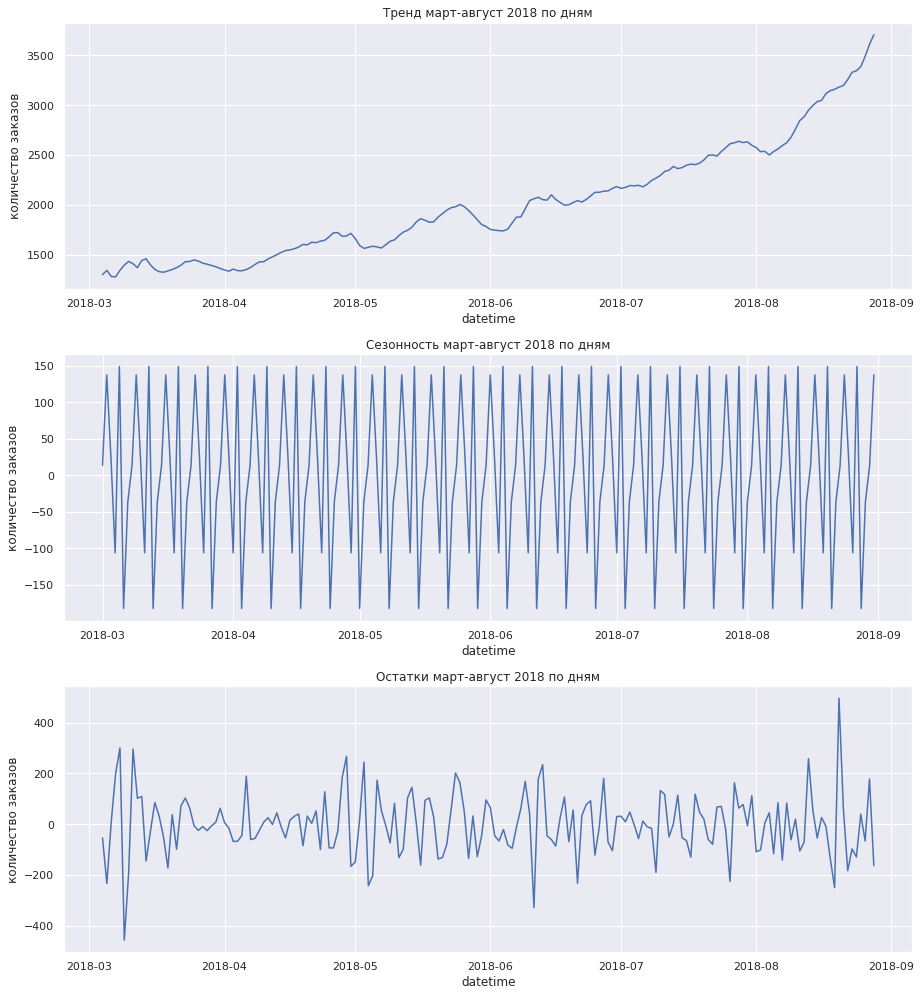

In [98]:
plt.figure(figsize = (13,14))
plt.subplot(311)
w=sns.lineplot(data=decomposed.trend)
w.set(title='Тренд март-август 2018 по дням', ylabel='количество заказов')
plt.subplot(312)
w=sns.lineplot(data=decomposed.seasonal)
w.set(title='Сезонность март-август 2018 по дням', ylabel='количество заказов')
plt.subplot(313)
w=sns.lineplot(data=decomposed.resid)
w.set(title='Остатки март-август 2018 по дням', ylabel='количество заказов')
plt.tight_layout()

Изучим сезонность за 14 дней марта:

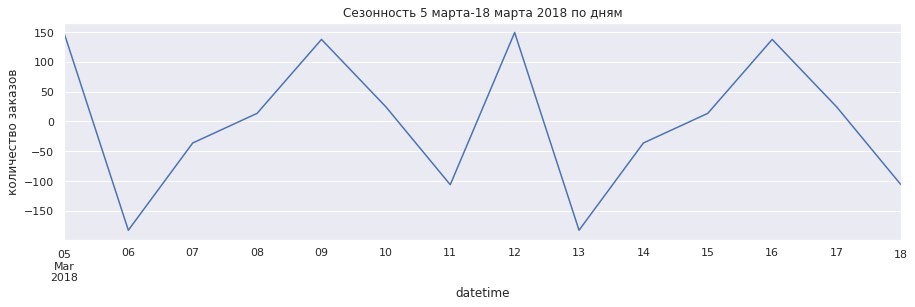

In [99]:
sns.set(rc={'figure.figsize':(15,4)})
w = decomposed.seasonal['2018-03-05':'2018-03-18'].plot()
w.set(title='Сезонность 5 марта-18 марта 2018 по дням', ylabel='количество заказов')
plt.show()

Пик заказов такси приходится на выходные и середину недели.

<b>Вывод:</b>
- в изучаемом периоде наблюдается увеличение количества заказов такси в аэропорт, больше всего заказов в августе, что вероятней всего, связано с периодом отпусков;
- тренд со временем растет, значительный рост наблюдается с мая и усиливается в июле-августе;
- данные имеют суточную и недельную сезонность:
    - пик заказов такси приходится на ночь, к утру происходит спад, затем в течение дня количество заказов постепенно растет;
    - пик заказов такси приходится на выходные и середину недели.

## 3. Обучение

### 3.1. Подготовка признаков для построения моделей

На основании проведенного в п.2 анализа создадим важные для обучения признаки:
- сезонность в течение дня --> добавим признак, обозначающий  час;
- сезонность в течение недели --> добавим признак, обозначающий день недели.

К этим признакам добавим:
- предыдущие значения временного ряда;
- скользящее среднее, которое задаёт общий тренд временного ряда.

In [100]:
# Функцию для создания признаков:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = pd.to_datetime(data.index).hour
    data['dayofweek'] = pd.to_datetime(data.index).dayofweek
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [101]:
# Функция, разделяющая данные на обучающую и тестовую выборки
def get_features(data):
    features = data.drop('num_orders', axis=1)
    target = data['num_orders']
    # выделение 10% данных для тестовой выборок, остальные 90% — для обучающей
    features_train, features_test, target_train, target_test = train_test_split(
        features, target, shuffle=False, test_size=0.10)
    return features_train, features_test, target_train, target_test

При выборе размера окна и количества остающих значений мы можем использовать имеющуюся у нас информацию о сезонности, суточной или недельной.
Создадим признаки с учетом суточной сезонности, возьмем max_lag и rolling_mean_size равными 24 (сутки):

In [102]:
make_features(data_h, 24, 24);

Удалим отсутствующие значения в признаках:

In [103]:
data_h = data_h.dropna()

Разделим данные на обучающую и тестовую выборки:

In [104]:
features_train, features_test, target_train, target_test = get_features(data_h)
print(features_train.shape, target_train.shape)
features_test.shape, target_test.shape

(3952, 27) (3952,)


((440, 27), (440,))

### 3.2. Построение модели

Потроим 4 модели: линейную регрессию, решающее дерево, случайный лес и градиентный бустинг.

In [105]:
RANDOM_STATE = 12345

In [106]:
tscv = TimeSeriesSplit(n_splits=3)

#### Модель - линейная регрессия

Объявление модели:

In [107]:
model_lr = LinearRegression()

Построение модели - линейная регрессия:

In [108]:
scores_lr = cross_val_score(model_lr, features_train, target_train, scoring='neg_root_mean_squared_error')
model_lr.fit(features_train, target_train)
print('RMSE для линейной регрессии:', -scores_lr.mean())

RMSE для линейной регрессии: 25.89102587885761


#### 3.2.1. Модель - решающее дерево

Объявление модели и параметров для нее:

In [109]:
model_dt = DecisionTreeRegressor(random_state=RANDOM_STATE)
parametrs = {'max_depth': range (5, 20, 5)}

Построение модели - решающее дерево:

In [110]:
grid_dt = GridSearchCV(model_dt, parametrs, cv=tscv, scoring='neg_root_mean_squared_error')

grid_dt.fit(features_train, target_train)
print('RMSE для решающего дерева:', -grid_dt.best_score_)
print('Наилучшие параметры модели:', grid_dt.best_params_)

RMSE для решающего дерева: 32.21567812183245
Наилучшие параметры модели: {'max_depth': 5}


#### 3.2.2. Модель - случайный лес

Объявление модели и параметров для нее:

In [111]:
model_rf = RandomForestRegressor(random_state=RANDOM_STATE)
parametrs = {'n_estimators': range (10, 30, 10),
             'max_depth': range (5, 20, 5)}

Построение модели - случайный лес:

In [112]:
grid_rf = GridSearchCV(model_rf, parametrs, cv=tscv, scoring='neg_root_mean_squared_error')

grid_rf.fit(features_train, target_train)
print('RMSE для случайного леса:', -grid_rf.best_score_)
print('Наилучшие параметры модели:', grid_rf.best_params_)

RMSE для случайного леса: 27.590850072259073
Наилучшие параметры модели: {'max_depth': 15, 'n_estimators': 20}


#### 3.2.3. Модель - градиентый бустинг (библиотеки LightGBM)

Объявление модели и параметров для нее:

In [113]:
model_gb = LGBMRegressor()
parametrs = {'num_leaves': range(2, 5)}

Построение модели - градиентный бустинг:

In [114]:
grid_gb = GridSearchCV(model_gb, parametrs, cv=tscv, scoring='neg_root_mean_squared_error')

grid_gb.fit(features_train, target_train)
print('RMSE для градиентного бустинга:', -grid_gb.best_score_)
print('Наилучшие параметры модели:', grid_gb.best_params_)

RMSE для градиентного бустинга: 26.68907628300491
Наилучшие параметры модели: {'num_leaves': 4}


### 3.3. Выбор лучшей модели

In [115]:
models_title = ['линейная регрессия', 'решающее дерево', 'случайный лес', 'градиентный бустинг']
result = {
    'RMSE': [-scores_lr.mean(), -grid_dt.best_score_, -grid_rf.best_score_, -grid_gb.best_score_]
}
pd.DataFrame(data=result, index=models_title)

,RMSE
линейная регрессия,25.891026
решающее дерево,32.215678
случайный лес,27.590850
градиентный бустинг,26.689076


<b>Вывод:</b>
 В результате исследования определено:
- по качеству (RMSE) :
    - самое высокое качество у линейной регрессии, RMSE равно <b>25.89</b>;
    - на втором месте - градиентный бустинг, RMSE равно <b>26.69</b> с гиперпараметром:
        - num_leaves = 4;
    - на третьем месте — случаный лес, RMSE равно <b>27.59</b> с гиперпараметрами:
        - max_depth = 15, 
        - n_estimators = 20;
    - самое низкое качество предсказания у решающего дерева, RMSE равно <b>32.22</b> с гиперпараметром:
        - max_depth = 5.

## 4. Тестирование

### 4.1. Проверка лучшей модели на тестовых данных:

Выберем модель - линейная регрессия и проверим ее на тестовых данных.

In [116]:
predicted_test_lr = model_lr.predict(features_test)
rmse_test_lr = mean_squared_error(target_test, predicted_test_lr, squared=False)
print('RMSE линейной регрессии:', rmse_test_lr)

RMSE линейной регрессии: 45.224094905317585


### 4.2. Проверка модели на адекватность

Для проверки адекватности создадим pred_previous, равный предыдущим значением ряда и вычислим RMSE такого предсказания:

In [117]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]
print('RMSE:', mean_squared_error(target_test, pred_previous, squared=False))

RMSE: 58.881776776551476


<b>Вывод:</b> 
В результате тестирования определено:
- линейная регрессия имеет RMSE равное <b>45.22</b>;
- построенная модель прошла поверку на адекватность.

<b>ОБЩИЕ ВЫВОДЫ:</b>

В результате анализа данных определено:

- временной ряд содержит данные с марта по август 2018 года;
- в изучаемом периоде наблюдается увеличение количества заказов такси в аэропорт, больше всего заказов в августе, что связано с периодом отпусков;
- тренд со временем растет, значительный рост наблюдается с мая и усиливается в июле-августе;
- данные имеют суточную и недельную сезонность:
    - пик заказов такси приходится на ночь, к утру происходит спад, затем в течение дня количество заказов постепенно растет;
    - пик заказов такси приходится на выходные и середину недели.

В результате исследования определено:
- по качеству (RMSE) :
    - самое высокое качество у линейной регрессии, RMSE равно <b>25.89</b>;
    - на втором месте - градиентный бустинг, RMSE равно <b>26.69</b> с гиперпараметром:
        - num_leaves = 4;
    - на третьем месте — случаный лес, RMSE равно <b>27.59</b> с гиперпараметрами:
        - max_depth = 15, 
        - n_estimators = 20;
    - самое низкое качество предсказания у решающего дерева, RMSE равно <b>32.22</b> с гиперпараметром:
        - max_depth = 5.
        
В результате тестирования определено:
- линейная регрессия имеет RMSE равное <b>45.22</b>;
- построенная модель прошли поверку на адекватность.